In [1]:
import os
import glob
import matplotlib.pyplot as plt

In [2]:
#  kaggle dataset https://www.kaggle.com/datasets/michaelarman/poemsdataset/data\
sentences = []
def read_and_write_files(input_folder, topic_list):
    for root, dirs, files in os.walk(input_folder):
        for file in files:
            if file.endswith('.txt') and root.split('/')[1] in topic_list:
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as infile:
                    content = infile.read()
                    sentences.append(content.lower().split('\n'))

# Define the input folder and the output file
input_folder = 'topics'
topic_list = ['cinderella']

# Call the function to read and write files
read_and_write_files(input_folder, topic_list)
print(len(sentences))

100


In [3]:
sentences

[['gently into the bright future i sway;',
  'then i met her so fair on my way and',
  'to her beauty a gaze i never say nay. for',
  'in her i see the face of my cinderella.',
  'her fairness no comparism, my confession-',
  'be of the damsel who in heart is full of passion. that',
  "my desire of her i cannot hold back my emotion'",
  'to call her my cinderella.',
  'the dance of her beauty leaves no measure.',
  'capturing my fantasy in great pleasure;',
  'forever with her be my time leisure',
  'to always have a dance with her, my cinderella.',
  'round in the shadowy whirl wind of fantasy;',
  'goes a great sense of me ecstasy-',
  'with streams of passionate intimacy',
  'to always behold her so pretty- my cinderella.',
  'behold! illusions now come to reality.',
  'imagination in great confidence calleth opportunity',
  "featuring the heart in that sense of utility'",
  'of having the one who shall be my cinderella.',
  'shall i not look upon your beauty, that',
  'like a dance

In [4]:
from langdetect import detect, DetectorFactory
from langdetect.lang_detect_exception import LangDetectException

DetectorFactory.seed = 0

In [5]:
english_poems = []
for sentence in sentences:
    try:
        if detect(str(sentence)) == 'en':
            english_poems.append(sentence)
    except LangDetectException:
        pass
print(len(english_poems))

100


In [7]:
import string

translation_table = str.maketrans('', '', string.punctuation)

# lowercase
new_sentences = [str(sentence).lower() for sentence in english_poems]

# remove punctuation
corpus = [sentence.translate(translation_table) for sentence in new_sentences]
print(len(corpus))

100


In [9]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import numpy as np

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1 # 1 for padding
print('vocabulary size', vocab_size)

vocabulary size 3709


Generate n grams

In [11]:
n_grams = []

for sentence in corpus:
    # convert sentence to tokens
    tokens = tokenizer.texts_to_sequences([sentence])[0]
    for i in range(2, len(tokens)+1):
        # extract n-gram
        n_gram = tokens[:i]
        # save n-gram
        n_grams.append(n_gram)

max_sequence_len = max([len(x) for x in n_grams])

print(f"Number of n-grams: {len(n_grams)}")
print(f"Maximum n-gram length: {max_sequence_len}")


Number of n-grams: 18525
Maximum n-gram length: 2284


In [12]:
padded_n_grams = np.array(pad_sequences(n_grams, maxlen=100, padding="pre", truncating="pre"))

padded_n_grams.shape

(18525, 100)

In [13]:
X = padded_n_grams[:, :-1]
y = padded_n_grams[:, -1]

print(f"X: {X.shape}")
print(f"y: {y.shape}")

X: (18525, 99)
y: (18525,)


In [14]:
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

print(f"y: {y.shape}")

y: (18525, 3709)


In [15]:
model = tf.keras.Sequential([
    Embedding(vocab_size, 300, input_length=99),
    LSTM(150),
    Dense(vocab_size, activation="softmax"),
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/Users/diwakar_rj/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.fit(
    X, 
    y, 
    epochs=100,
    batch_size=128,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="loss", patience=20)
    ],
)

Epoch 1/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 33s 215ms/step - accuracy: 0.0367 - loss: 7.3225
Epoch 2/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 30s 204ms/step - accuracy: 0.0528 - loss: 6.4408
Epoch 3/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 195ms/step - accuracy: 0.0553 - loss: 6.3145
Epoch 4/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 190ms/step - accuracy: 0.0695 - loss: 6.1575
Epoch 5/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.0831 - loss: 5.9855
Epoch 6/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.0930 - loss: 5.8460
Epoch 7/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.1012 - loss: 5.6584
Epoch 8/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 28s 192ms/step - accuracy: 0.1086 - loss: 5.5176
Epoch 9/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 32s 217ms/step - accuracy: 0.1205 - loss: 5.3195
Epoch 10/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 29s 200ms/step - accuracy: 0.1330 - loss: 5.1772
Epoch 11/100
145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 187ms/step - accuracy: 0.1523 - loss: 5.0052
Epoch 12

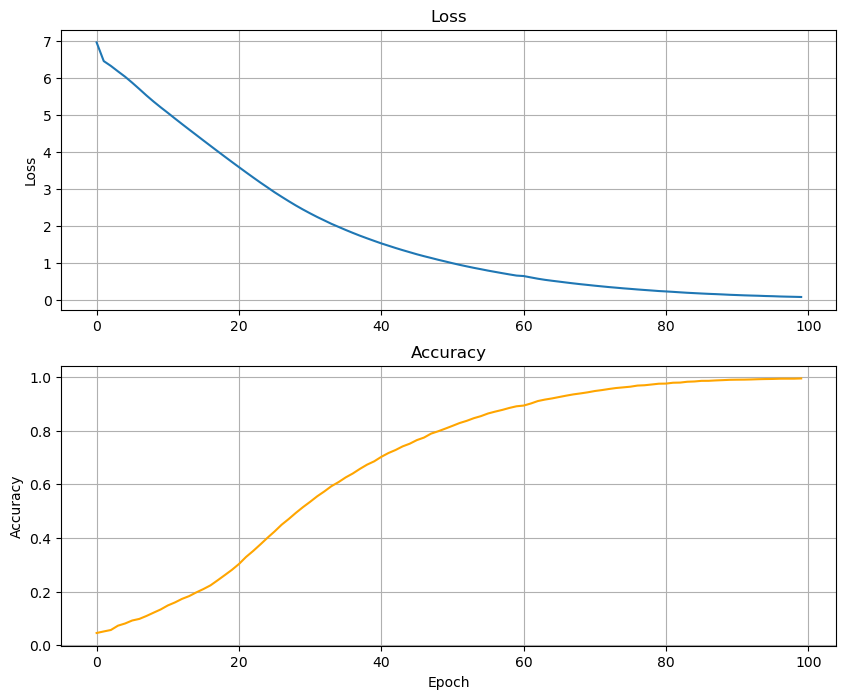

In [17]:
hist = model.history.history

plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(hist["loss"])
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(hist["accuracy"], color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

In [18]:
def generate(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=99, padding="pre")
        predicted = np.argmax(model.predict(token_list, verbose=0))
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    print(seed_text)  

In [19]:
generate("Hello there", 200)

Hello there was a letter in the mail i dreamed that night about a woman named tara mchale although there were those lips that pout it was the presence of a breeze made up of warmth and intellect she stopped for just a minute just to tease yet it was futile and i was not able to detect more than the pheromones of something great of youth and fresh aroma passing through of silent whispers knitting silk for a debate she left behind for me her cinderella shoe the next day he surprised adelaida by knocking at the blood pouring forth that is the way so she simply sliced it off and put on the slipper the prince rode away with her until the white dove told him to look at the blood pouring forth that is the way with amputations they just dont heal up like a wish the other sister cut off her heel but the blood told as blood will the prince was getting tired he began to feel like a shoe salesman but he gave it one last try this time cinderella fit into the shoe like a love letter into its envelop

In [21]:
generate("It was a wonderful time", 100)

It was a wonderful time there was a revolver to torture him and there the prince himself charming the prince himself was turned to pulp all he could do take a mask dance party we only dance once but last a lifetime it was a magical time even thought we never saw each other face but you remember how beautiful i want to wake you up from endless sleep to teach you poisoned apples not to eat i m in love with the powers of your words climbing in my desert like gorgious dolls i dont know the colour of your eyes but when i


In [23]:
generate("kiss my neck", 50)

kiss my neck and i’m not cinderella and my name was cinderella but i can’t breathe whenever you’re with me can you feel my heartbeat in my chest it’s getting faster every second time slows down you are better than the best but would you feel the same if my name was cinderella


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 99, 300)        │     1,112,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 150)            │       270,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3709)           │       560,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,830,079 (22.24 MB)

 Trainable params: 1,943,359 (7.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,886,720 (14.83 MB)

In [ ]:
input_sequences = []

for line in poems_corpus:
    sequence = tokenizer.texts_to_sequences([line])[0] #pass line as list - output of text to sequence is an array
    for i in range(1, len(sequence)):
        n_gram_sequence = sequence[:i+1]
        input_sequences.append(n_gram_sequence)

max_sequence_length = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=100,
                                        padding='pre', truncating="pre"))
x, labels = input_sequences[:,:-1], input_sequences[:,-1]
y = tf.keras.utils.to_categorical(labels, num_classes=total_words)

In [11]:
print(tokenizer.word_index.items())

dict_items([('the', 1), ('and', 2), ('to', 3), ('a', 4), ('her', 5), ('in', 6), ('of', 7), ('she', 8), ('i', 9), ('cinderella', 10), ('you', 11), ('was', 12), ('for', 13), ('with', 14), ('that', 15), ('my', 16), ('is', 17), ('it', 18), ('on', 19), ('not', 20), ('but', 21), ('be', 22), ('me', 23), ('prince', 24), ('as', 25), ('all', 26), ('one', 27), ('he', 28), ('no', 29), ('your', 30), ('love', 31), ('from', 32), ('like', 33), ('have', 34), ('so', 35), ('will', 36), ('at', 37), ('this', 38), ('never', 39), ('we', 40), ('their', 41), ('would', 42), ('are', 43), ('they', 44), ('there', 45), ('by', 46), ('who', 47), ('just', 48), ('were', 49), ('out', 50), ('when', 51), ('what', 52), ('now', 53), ('day', 54), ('his', 55), ('up', 56), ('time', 57), ('do', 58), ('come', 59), ('can', 60), ('girl', 61), ('could', 62), ('if', 63), ('adelaida', 64), ('then', 65), ('or', 66), ('had', 67), ('where', 68), ('am', 69), ('into', 70), ('heart', 71), ('ball', 72), ('each', 73), ('marisol', 74), ('danc

In [13]:
print(tokenizer.word_index['mother'])
print(tokenizer.word_index['awaited'])

84
3664


In [28]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_length-1))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
model.history = model.fit(x, y, epochs=5, verbose=1)

Epoch 1/5
579/579 ━━━━━━━━━━━━━━━━━━━━ 444s 768ms/step - accuracy: 0.0521 - loss: 6.6816
Epoch 2/5
579/579 ━━━━━━━━━━━━━━━━━━━━ 421s 727ms/step - accuracy: 0.0568 - loss: 6.3922
Epoch 3/5
579/579 ━━━━━━━━━━━━━━━━━━━━ 438s 756ms/step - accuracy: 0.0688 - loss: 6.1325
Epoch 4/5
579/579 ━━━━━━━━━━━━━━━━━━━━ 425s 735ms/step - accuracy: 0.0800 - loss: 5.9434
Epoch 5/5
579/579 ━━━━━━━━━━━━━━━━━━━━ 422s 729ms/step - accuracy: 0.0835 - loss: 5.8103


In [32]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 2283, 100)      │       370,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3709)           │       374,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,417,729 (9.22 MB)

 Trainable params: 805,909 (3.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,611,820 (6.15 MB)

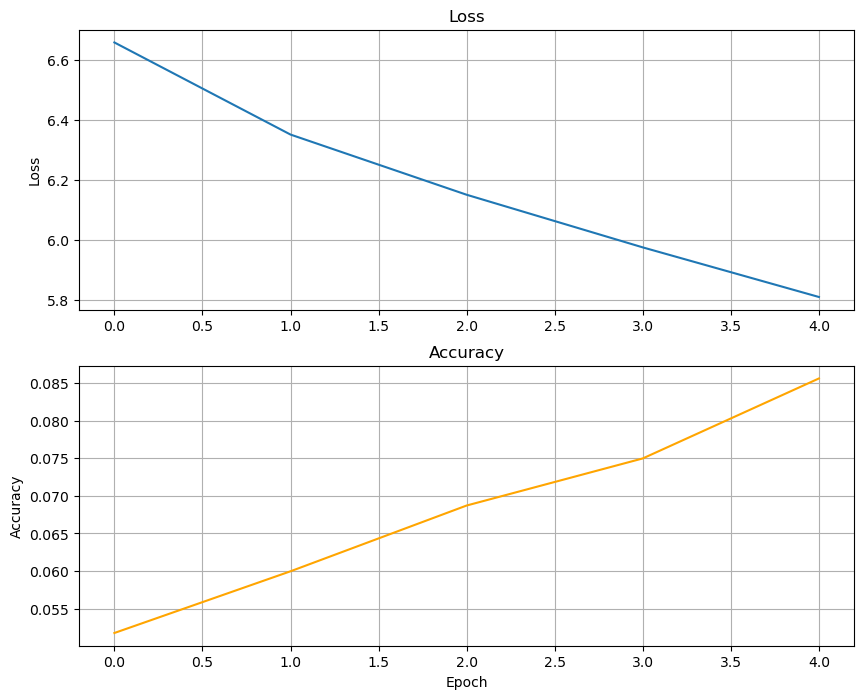

In [35]:
hist = model.history.history
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.title("Loss")
plt.plot(hist["loss"])
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.title("Accuracy")
plt.plot(hist["accuracy"], color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.show()

In [39]:
def generate_poem(input_word, word_length):
    
    for _ in range(word_length):
        token_list = tokenizer.texts_to_sequences([input_word])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_length,
                                  padding = 'pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        output = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output = word
                break
        input_word = input_word + ' ' + output
    return input_word


generate_poem("Hello there", 200)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1

'Hello there the prince cinderella the prince cinderella the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince of the prince'